# Offline Handwriting Recognition using CNN

I've built this using Keras in Python with TensorFlow as backend. This model is language independent as we dont consider the letters or words in particular, but patches of image size 113x113 are extracted and fit into the model for learning. 


## Dataset
[IAM Handwritten Dataset](https://www.kaggle.com/tejasreddy/iam-handwriting-top50)

## Reference 
https://tejasreddy9.github.io/handwriting_cnn/

### Imports
Import these packages to the project.

In [1]:
from __future__ import division
import numpy as np
import os
import glob

from random import *
from PIL import Image
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam, RMSprop

These are the forms in the dataset for quick access from manipulation of the file names on each column. Let's create a dictionary with form and writer mapping.

In [2]:
d = {}
from subprocess import check_output

with open('data/forms_for_parsing.txt') as f:
    for line in f:
        key = line.split(' ')[0]
        writer = line.split(' ')[1]
        d[key] = writer
print(len(d.keys()))

1539


All file-names list and target-writer names list are created.

In [3]:
tmp = []
target_list = []

path_to_files = os.path.join('data\\data_subset\\data_subset\\', '*')
for filename in sorted(glob.glob(path_to_files)):
    tmp.append(filename)
    image_name = filename.split('\\')[-1]
    file, ext = os.path.splitext(image_name)
    parts = file.split('-')
    form = parts[0] + '-' + parts[1]
    for key in d:
        if key == form:
            target_list.append(str(d[form]))

img_files = np.asarray(tmp)
img_targets = np.asarray(target_list)
print(img_files.shape)
print(img_targets.shape)

(4899,)
(4899,)


### Visualization of images
Let's visualize the image data.

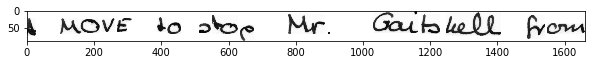

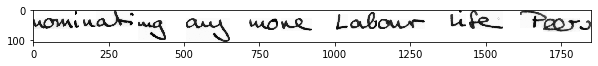

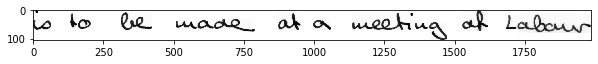

In [4]:
for filename in img_files[:3]:
    img=mpimg.imread(filename)
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap ='gray')

Good to observe that there are no categorical data. So, normalisation is done using label encoder.

In [5]:
encoder = LabelEncoder()
encoder.fit(img_targets)
encoded_Y = encoder.transform(img_targets)

print(img_files[:5], img_targets[:5], encoded_Y[:5])

['data\\data_subset\\data_subset\\a01-000u-s00-00.png'
 'data\\data_subset\\data_subset\\a01-000u-s00-01.png'
 'data\\data_subset\\data_subset\\a01-000u-s00-02.png'
 'data\\data_subset\\data_subset\\a01-000u-s00-03.png'
 'data\\data_subset\\data_subset\\a01-000u-s01-00.png'] ['000' '000' '000' '000' '000'] [0 0 0 0 0]


Splitting of data into training and validation sets for cross validation with 4:1:1 ratio.

In [6]:
train_files, rem_files, train_targets, rem_targets = train_test_split(
        img_files, encoded_Y, train_size=0.66, random_state=52, shuffle= True)

validation_files, test_files, validation_targets, test_targets = train_test_split(
        rem_files, rem_targets, train_size=0.5, random_state=22, shuffle=True)

print(train_files.shape, validation_files.shape, test_files.shape)
print(train_targets.shape, validation_targets.shape, test_targets.shape)

(3233,) (833,) (833,)
(3233,) (833,) (833,)


### Input to the model

As said before, we take patches of data, each of size 113x133. A generator function is implemented for that purpose.

In [7]:
# Generator function for generating random crops from each sentence

# # Now create generators for randomly cropping 113x113 patches from these images

batch_size = 16
num_classes = 50

# Start with train generator shared in the class and add image augmentations
def generate_data(samples, target_files,  batch_size=batch_size, factor = 0.1 ):
    num_samples = len(samples)
    from sklearn.utils import shuffle
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_targets = target_files[offset:offset+batch_size]

            images = []
            targets = []
            for i in range(len(batch_samples)):
                batch_sample = batch_samples[i]
                batch_target = batch_targets[i]
                im = Image.open(batch_sample)
                cur_width = im.size[0]
                cur_height = im.size[1]

                # print(cur_width, cur_height)
                height_fac = 113 / cur_height

                new_width = int(cur_width * height_fac)
                size = new_width, 113

                imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
                now_width = imresize.size[0]
                now_height = imresize.size[1]
                # Generate crops of size 113x113 from this resized image and keep random 10% of crops

                avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

                # Pick random x%
                pick_num = int(len(avail_x_points)*factor)

                # Now pick
                random_startx = sample(avail_x_points,  pick_num)

                for start in random_startx:
                    imcrop = imresize.crop((start, 0, start+113, 113))
                    images.append(np.asarray(imcrop))
                    targets.append(batch_target)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(targets)

            #reshape X_train for feeding in later
            X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)
            #convert to float and normalize
            X_train = X_train.astype('float32')
            X_train /= 255

            #One hot encode y
            y_train = to_categorical(y_train, num_classes)
            yield shuffle(X_train),shuffle(y_train)

For training and testing,  generator function is called with the intent of making train and test generator data.

In [8]:
train_generator = generate_data(train_files, train_targets, batch_size=batch_size, factor = 0.3)
validation_generator = generate_data(validation_files, validation_targets, batch_size=batch_size, factor = 0.3)
test_generator = generate_data(test_files, test_targets, batch_size=batch_size, factor = 0.1)

A Keras Model is built. Summary of the model is printed below.

In [9]:
def resize_image(image):
    import tensorflow as tf
    return tf.image.resize(image,[56,56])

row, col, ch = 113, 113, 1

model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))

# Resise data within the neural network
model.add(Lambda(resize_image))  #resize images to allow for easy computation

# CNN model - Building the model suggested in paper

model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2,2), padding='same', name='conv1')) #96
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))

model.add(Convolution2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same', name='conv2'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))

model.add(Convolution2D(filters= 128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(512, name='dense1'))  #1024
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256, name='dense2'))  #1024
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax'))  #softmax since output is within 50 classes

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 115, 115, 1)       0         
_________________________________________________________________
lambda (Lambda)              (None, 56, 56, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 64)        0

### Training the model

Let's take 8 epochs. And the following specifications.

In [10]:
nb_epoch = 1
samples_per_epoch = 32
nb_val_samples = 8

#save every model using Keras checkpoint
from keras.callbacks import ModelCheckpoint
filepath="checkpoint2/check-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath= filepath, verbose=1, save_best_only=False)
callbacks_list = [checkpoint]

#Model fit generator
history_object = model.fit_generator(train_generator, steps_per_epoch= samples_per_epoch,
                                     validation_data=validation_generator,
                                     validation_steps=nb_val_samples, epochs=nb_epoch, verbose=1)

model.save('output/model.h5')

C:\Users\91758\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


32/32 [==============================] - 426s 11s/step - loss: 3.8793 - accuracy: 0.1682 - val_loss: 3.8735 - val_accuracy: 0.2058


### Predictions

In [11]:
images = []
for filename in test_files[:50]:
    im = Image.open(filename)
    cur_width = im.size[0]
    cur_height = im.size[1]

    # print(cur_width, cur_height)
    height_fac = 113 / cur_height

    new_width = int(cur_width * height_fac)
    size = new_width, 113

    imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
    now_width = imresize.size[0]
    now_height = imresize.size[1]
    # Generate crops of size 113x113 from this resized image and keep random 10% of crops

    avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

    # Pick random x%
    factor = 0.1
    pick_num = int(len(avail_x_points)*factor)
    
    random_startx = sample(avail_x_points,  pick_num)

    for start in random_startx:
        imcrop = imresize.crop((start, 0, start+113, 113))
        images.append(np.asarray(imcrop))
        
    X_test = np.array(images)
    
    X_test = X_test.reshape(X_test.shape[0], 113, 113, 1)
    #convert to float and normalize
    X_test = X_test.astype('float32')
    X_test /= 255
    shuffle(X_test)

print(X_test.shape)

(6351, 113, 113, 1)


Load in test data.

In [12]:
predictions = model.predict(X_test, verbose =1)

print(predictions.shape)
predicted_writer = []
for pred in predictions:
    predicted_writer.append(np.argmax(pred))
print(len(predicted_writer))

199/199 [==============================] - 4s 17ms/step
(6351, 50)
6351


In [13]:
scores = model.evaluate_generator(test_generator,round(len(test_files)/batch_size)) 
print("Accuracy = ", scores[1])

C:\Users\91758\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Accuracy =  0.25500357151031494
